In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_pmi(P,M):
    
    plt.plot(M,P,".")

    plt.xlabel("Moment [kip-ft]")
    plt.ylabel("Axial [kip]")
    plt.title("P-M Interaction Diagram")
    plt.rcParams["figure.figsize"] = (10,10)
    plt.grid(True)

    plt.show()
    
def calc_beta1(fc):
    return 0.85-0.05*(fc-4000)/1000

def calc_ecl_non_ps(fy, Es):
    if fy <= 60000.:
        ecl = min(fy/Es, 0.002)
    elif fy > 60000. and fy <= 100000.:
        ecl = 0.002 + (0.004-0.002) * (fy - 60000.)/(100000. - 60000.)
        
    return ecl

def calc_etl_non_ps(fy):
    if fy <=75000.:
        etl = 0.005
    elif fy > 75000. and fy <=100000.:
        etl = 0.005 + (0.008-0.005) * (fy - 75000.)/(100000. - 75000.)
        
    return etl

def calc_phi_non_ps(es, ecl, etl):
    if es <= ecl: #compression-controlled w/ spirals or ties
        phi = 0.75
    elif es > ecl and es <= etl: #transition
        phi = 0.75 + (0.9-0.75) * (es - ecl)/(etl - ecl)
    elif es > etl: #tension-controlled
        phi = 0.9
        
    return phi

def apply_aashto_capacity_reduction(es,fy,Es,p,m):
    ecl = calc_ecl_non_ps(fy, Es)
    etl = calc_etl_non_ps(fy)
    phi = calc_phi_non_ps(es, ecl, etl)
    
    return phi*p, phi*m



def calc_zeta(con_reinf):
    if con_reinf == "Spiral":
        zeta = 0.85 
    elif con_reinf == "Tied":
        zeta = 0.80
        
    return zeta
    
def calc_kc(fc):
    if fc < 10000:
        kc = 0.85
    elif fc >= 10000:
        kc = min(0.75, 0.85 - 0.02*(10000-fc))

    return kc

def calc_aashto_axial(kc, fc, Ag, Ast, fy, zeta):
    #Pn_AASHTO = zeta*(kc(fc)*fc*(Ag-Ast-Aps)+fy*Ast-Aps*(fpe-Ep*ecu))
    Pn_AASHTO = zeta*(kc*fc*(Ag-Ast)+fy*Ast)
    
    return Pn_AASHTO




def apply_aashto_axial_limit(pn, fc, Ag, Ast, fy, con_reinf):
    kc = calc_kc(fc)
    zeta = calc_zeta(con_reinf)
    
    pn_aashto = calc_aashto_axial(kc, fc, Ag, Ast, fy, zeta)
    
    return min(pn, pn_aashto)



def apply_conversion(p,m):
    p = p/1000.0
    m = m/1000.0/12.0
    
    return p,m




def steel_strain_stress(es, fy, Es):
    fs = np.sign(es)*min(abs(es)*Es, fy)

    return fs

In [30]:
def pm(eu, Es, fy, fc, Ec, h, b, d1, d2, d3, As1, As2, As3):
    c_start = 0.0
    c_end = h
    num_steps = 100
    c_step = (c_end-c_start)/num_steps

    p = []
    m = []
    es_ext = []

    for x in range(num_steps):
        if x == 0:
            c = c_step
        else:
            c = c + c_step

        phi = math.log(eu/c, 10)

        a = 0.85*c
        es1 = eu*(c-d1)/c
        fs1 = steel_strain_stress(es1, fy, Es)
        es2 = eu*(c-d2)/c
        fs2 = steel_strain_stress(es2, fy, Es)
        es3 = eu*(c-d3)/c
        fs3 = steel_strain_stress(es3, fy, Es)
        comp = 0.85*fc*a*b
        pn = comp+fs1*As1+fs2*As2+fs3*As3
        mn = comp*(h/2-a/2)+As2*fs2*(h/2-d1)+As1*(fs1)*(d1-h/2)+As3*(fs3)*(d3-h/2)

        if mn >= 0.0: #removes values to the left of the vertical axis
            
            out = ('c: {8}\na: {0}\nes: {1}\nfs: {2}\nesp: {3}\nfsp: {4}\nC: {5}\nPn:'
            '{6}\nMn: {7}'.format(a,es1,fs1,es2,fs2,es3,fs3,comp,pn,mn,c))

            #print(out)

            #print(Pn, ",", Mn, ",", es1)
            p.append(pn)
            m.append(mn)
            es_ext.append(es1)
        
    return p, m, es_ext

1727.2152 -442.569375 339.7732245


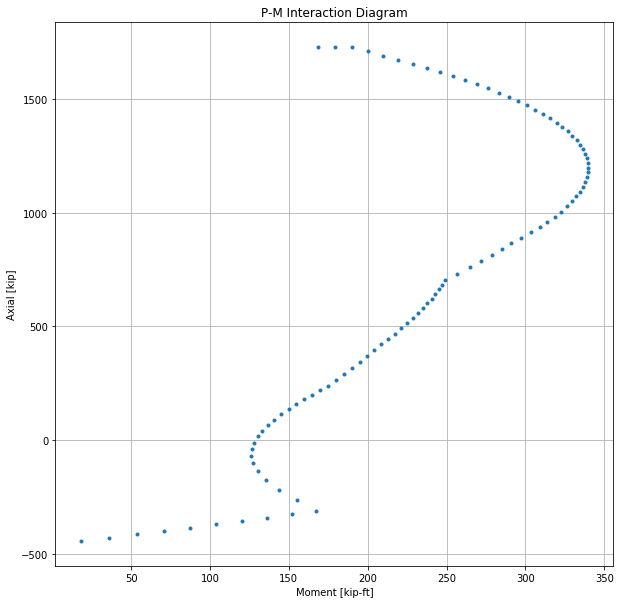

In [31]:
eu = 0.003
Es = 29000000
fy = 60000
fc = 3000
Ec = 3625.
h = 30.
b = 30.
d1 = 24.87
d2 = 5.14
d3 = 15
As1 = 3.*1.27
As2 = 3.*1.27
As3 = 2*1.27
con_reinf = "Tied"

Ast = As1 + As2 + As3
Ag = b*h

p1,m1,es = pm(eu, Es, fy, fc, Ec, h, b, d1, d2, d3, As1, As2, As3)

p1 = [apply_aashto_axial_limit(p, fc, Ag, Ast, fy, con_reinf) for p in p1]
    
p1, m1 = zip(*[apply_aashto_capacity_reduction(e,fy,Es,p,m) for e, p, m in zip(es, p1, m1)])

p1, m1 = zip(*[apply_conversion(p,m) for p,m in zip(p1,m1)])

print(max(p1), min(p1), max(m1))

i = 0
for e in es:
    error = 0.03
    if e >= fy/Es*(1-error) and e <= fy/Es*(1+error):
        print(e,i)
        print(p1[i], m1[i])
    i += 1

plot_pmi(p1,m1)